# Imports

In [26]:
DRP = "/Users/mudassar.iqbal/Library/CloudStorage/GoogleDrive-mdsriqb@gmail.com/My Drive/sign-language-translator/sign-language-datasets"

In [9]:
import os

from sign_language_translator.vision import visualization as vis
from sign_language_translator.vision import embed as vpp
from sign_language_translator.vision import transforms as T
from sign_language_translator.vision import concatenate as C
from sign_language_translator.utils.landmarks_info import LandmarksInfo as li
from sign_language_translator.utils import tree
from sign_language_translator.data_collection import scraping
from sign_language_translator.text import subtitles as subs

from importlib import reload
# reload(vpp)


# math
import torch
import numpy as np
# from scipy.interpolate import interp1d
# from scipy.spatial.transform import Rotation as R
# from scipy.signal import find_peaks
# from skimage.transform import estimate_transform, warp

# Image processing
import cv2
import PIL
from PIL.Image import fromarray as np2pil

# visualization
import matplotlib.pyplot as plt
# import seaborn as sns
import moviepy.editor as mpy
# from moviepy.video.io.bindings import mplfig_to_npimage
# from moviepy.video.VideoClip import DataVideoClip

# directory
import os
import sys
from glob import glob

# notebook
from tqdm.auto import tqdm
from IPython.display import clear_output, Image, Video

# dataset
import json
import pandas as pd
tqdm.pandas()

# text processing
import urduhack as uh

# typing
from typing import List, Set, Dict, Union

clear_output()

In [ ]:
tree(DRP, directory_only=True,ignore=['temp', "__pycache__", "__init__.py"])

In [161]:
word = 'd-D'
# file reading
image_pose_multi_frame_landmarks = np.loadtxt(os.path.join('inputs', f'image_pose_{word}_person205_front.csv'), skiprows=1,delimiter=',')
pose_multi_frame_landmarks = np.loadtxt(os.path.join('inputs', f'pose_{word}_person205_front.csv'), skiprows=1,delimiter=',')
hand_multi_frame_landmarks = np.loadtxt(os.path.join('inputs', f'hand_{word}_person205_front.csv'), skiprows=1,delimiter=',')

# fix error (mirror hands horizontally)
hand_multi_frame_landmarks[..., np.arange(42)*3] *= -1

# stacking
all_multi_frame_landmarks = np.concatenate([pose_multi_frame_landmarks,
                                            hand_multi_frame_landmarks], axis=-1)

idx = 37
pose = pose_multi_frame_landmarks[idx]
hand = hand_multi_frame_landmarks[idx]
all_ =  all_multi_frame_landmarks[idx]

n_frames= len(all_multi_frame_landmarks)

In [41]:
tree('../slt_ai/slt_ai/static/txt', directory_only=False, extra_line=True, ignore=["__pycache__", "temp"])

txt
├── W2V300dim5winBulk.txt
├── WordSubstitutionManagement.ipynb
├── en_ambiguous2resolved.json
├── en_firstSubword2compound.json
├── en_mini_embeddings.txt
├── en_supportedWord2file.json
├── en_supportedWords_embeddings.txt
├── file2english.txt
├── file2urdu.txt
├── ur_ambiguous2resolved.json
├── ur_firstSubword2compound.json
├── ur_mini_embeddings.txt
├── ur_supportedWord2file.json
└── ur_supportedWords_embeddings.txt


# MediaPipe Landmarks Chart

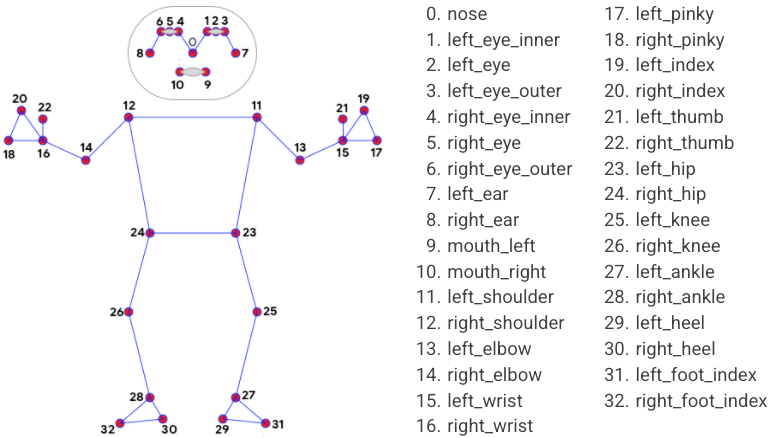

In [10]:
Image('data/mediapipe_pose_tracking_full_body_landmarks.png')

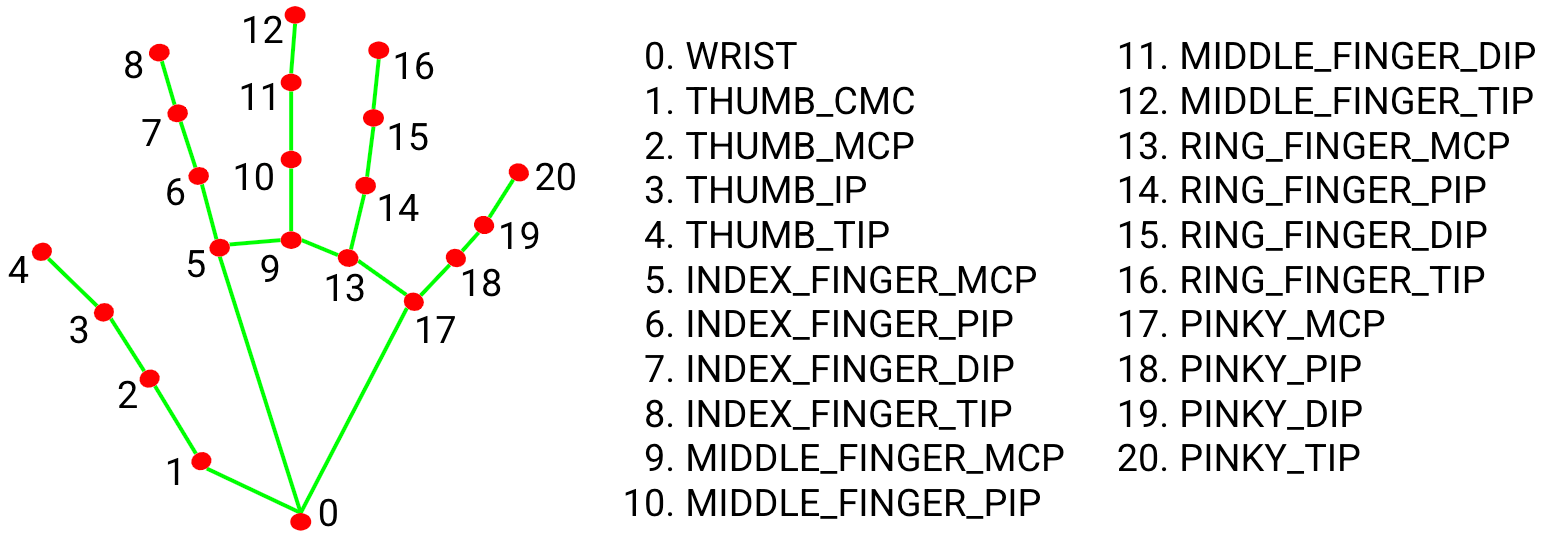

In [11]:
Image('data/mediapipe_hand_landmarks.png')

# text

In [44]:
# unigram, bigram, trigram, 5-gram, 7-gram, 9-gram, 12g, 15g, 18g, 22, 26, 30
np.round(np.linspace(1,30**0.5,12)**2).astype(int)
# train-test-split on phrases (or ngrams?), stratify on length/individual word frequency

array([ 1,  2,  3,  5,  7,  9, 12, 15, 18, 22, 26, 30])

In [61]:
print(subs.make_captions(['hello i am mudassar']*4, [2.1,0.9,1.2,3.5], [[0,5],[6,7],[8,10],[11,19]]))

WEBVTT

00:00:00.000 --> 00:00:02.100 line:60% align:left
<b>hello</b> i am mudassar

00:00:02.100 --> 00:00:03.000 line:60% align:left
hello <b>i</b> am mudassar

00:00:03.000 --> 00:00:04.200 line:60% align:left
hello i <b>am</b> mudassar

00:00:04.200 --> 00:00:07.700 line:60% align:left
hello i am <b>mudassar</b>


# training

In [ ]:
torch.optim.lr_scheduler.LambdaLR

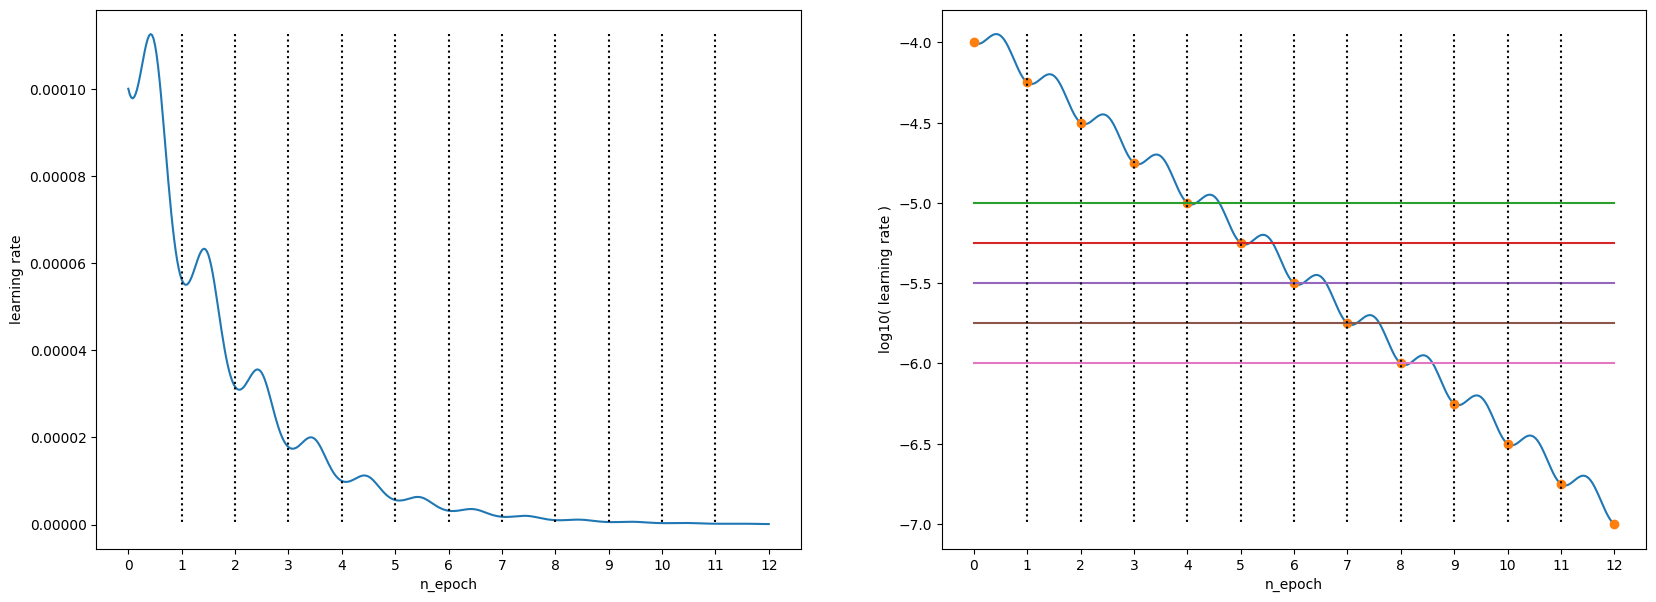

In [133]:
plt.figure(figsize=(20,7))

def lr(n_epochs, n_steps_per_epoch=9, start = 1e-3, end=1e-7):
    x = np.linspace(0,n_epochs,n_epochs*(1+n_steps_per_epoch)+1)

    start_exp, end_exp = np.log10(start), np.log10(end)

    decay = np.linspace(start_exp,end_exp,len(x))

    wave = np.sin(x*2*np.pi-np.pi/2)+1
    wave *= abs(start_exp-end_exp)/n_epochs/3

    final = wave + decay
    return final
    # return 10**final

start_exp, end_exp = -4,-7
start, end = 10**start_exp, 10**end_exp

n_epochs = abs(start_exp-end_exp)*4
n_steps_per_epoch = 35

plt.subplot(1,2,1)
y = 10**lr(n_epochs,n_steps_per_epoch=n_steps_per_epoch, start = start, end=end)
plt.plot(
    np.linspace(0,n_epochs,n_epochs*(1+n_steps_per_epoch)+1),
    y,
    '-'
)
x = np.arange(n_epochs+1)
plt.xticks(x)
for i in range(1,n_epochs):
    plt.plot([i,i],[max(y),min(y)], ':', color='black')
plt.xlabel('n_epoch')
plt.ylabel('learning rate')


plt.subplot(1,2,2)
y = lr(n_epochs,n_steps_per_epoch=n_steps_per_epoch, start = start, end=end)
plt.plot(
    np.linspace(0,n_epochs,n_epochs*(1+n_steps_per_epoch)+1),
    y,
    '-'
)
x = np.arange(n_epochs+1)
plt.xticks(x)
plt.plot(x,(end_exp-start_exp)/n_epochs*x+start_exp, 'o')
plt.plot([0,n_epochs],[start_exp-1,start_exp-1])
plt.plot([0,n_epochs],[start_exp-1.25,start_exp-1.25])
plt.plot([0,n_epochs],[start_exp-1.5,start_exp-1.5])
plt.plot([0,n_epochs],[start_exp-1.75,start_exp-1.75])
plt.plot([0,n_epochs],[start_exp-2,start_exp-2])
for i in range(1,n_epochs):
    plt.plot([i,i],[max(y),min(y)], ':', color='black')

plt.xlabel('n_epoch')
plt.ylabel('log10( learning rate )')
plt.show()
# unfreeze at epoch end / vertical dotted bar

# Motion Transfer
- screenshots where abs xy wrist speed is 0
- and gausian noise where landmarks were/should be
- train stable diffusion
- infer all frames of video in batch

In [89]:
from scipy.signal import convolve2d

In [300]:
xy = image_pose_multi_frame_landmarks[:,[16*4, 16*4+1]]
xy.shape

(67, 2)

In [301]:
n_repeats = 3

In [302]:
filter = np.repeat([[-1,1],[-1,1]],n_repeats,axis=1).T/n_repeats**2
filter, filter.shape

(array([[-0.11111111, -0.11111111],
        [-0.11111111, -0.11111111],
        [-0.11111111, -0.11111111],
        [ 0.11111111,  0.11111111],
        [ 0.11111111,  0.11111111],
        [ 0.11111111,  0.11111111]]),
 (6, 2))

In [303]:
grad = convolve2d(xy,filter,mode ='same' ,boundary='symm')
grad.shape

(67, 2)

In [304]:
grad_norm = np.linalg.norm(grad,axis=1)

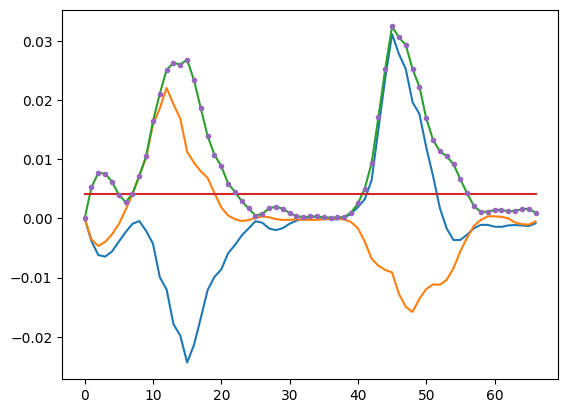

In [305]:
plt.plot(grad[:,0])
plt.plot(grad[:,1])
plt.plot(grad_norm)
plt.plot([0,66],[max(grad_norm)/8, max(grad_norm)/8])
plt.plot(grad_norm[grad_norm!=0], '.')

In [306]:
mask = grad_norm < max(grad_norm)/8
p_inv = grad_norm[mask]
p = p_inv.max() - p_inv
p /= np.sum(p)
p

array([0.04647832, 0.        , 0.01497302, 0.01314255, 0.02692918,
       0.04100384, 0.03729162, 0.02684842, 0.02370268, 0.02744228,
       0.03593979, 0.04176834, 0.04397835, 0.04256628, 0.04259074,
       0.04438198, 0.04488437, 0.04438283, 0.04367088, 0.0350658 ,
       0.01731271, 0.02290589, 0.03370313, 0.03327381, 0.02995434,
       0.02977222, 0.03286562, 0.03147391, 0.02884076, 0.0274328 ,
       0.03542355])

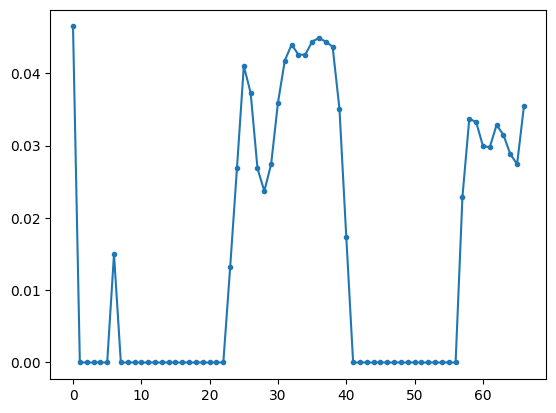

In [307]:
_ = np.zeros(len(xy))
_[mask] = p
plt.plot(_,'.-')

In [308]:
clip = mpy.VideoFileClip('inputs/d-D_person205_front.mp4')

In [322]:
np.random.choice(np.arange(len(xy))[mask], p=p)

6

In [ ]:
idx = np.random.choice(np.arange(len(xy))[mask], p=p)
print(idx)
ss = clip.get_frame(idx/len(xy[:-1])*clip.duration).copy()
# ss.setflags(write=1)
vis.np2pil(ss).reduce(4)

In [323]:
x,y = xy[6]
x,y = x*ss.shape[1], y*ss.shape[0]
y,x

(1120.3570175170898, 373.6924088001251)

In [324]:
size=(2, 50_000)
coords = np.rint(np.random.normal(0,0.025*np.mean(ss.shape[:2]),size) + [[x],[y]]).astype(int)

In [327]:
ss[coords[1],coords[0]] = (np.random.rand(coords.shape[1],3)*255).astype(np.uint8)

In [ ]:

ss+=(np.random.rand(*ss.shape)*255/50).astype(np.uint8)
vis.np2pil(ss).reduce(3)

# more